In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Métricas de Clasificación
from sklearn.metrics import (accuracy_score, f1_score, recall_score, 
                             precision_score, roc_auc_score, classification_report)
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# Modelos de Clasificación
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# -------------------------------------------------------------------------
# 1. PREPARACIÓN DE DATOS
# -------------------------------------------------------------------------
# Carga tu dataframe
df = pd.read_csv('../data/processed/clean_data.csv') 

# Definir Target de Clasificación
target_col = "Target_Campaign_Responsiveness"

# PRECAUCIÓN: Eliminamos el target actual 
# Eliminamos también el otro target y el 'ID'
cols_to_drop = [target_col, 'ID', 'Target_MntWinesYear']

X = df.drop(columns=cols_to_drop)
y = df[target_col]

# Split de entrenamiento y prueba
# IMPORTANTE: Usamos 'stratify=y' para mantener la proporción de 0s y 1s 
# en ambos conjuntos (vital en clasificación desbalanceada).
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=11,
    shuffle=True, # Por si los datos llegaran con algún orden
    stratify=y # Importante ya que tenemos más casos de 0 que de 1 en la cariable a predecir
)

print(f"Dimensiones de X_train: {X_train.shape}")
print("-------------------------------------------------------")
print(f"Distribución del Target en todo el dataset: \n{df["Target_Campaign_Responsiveness"].value_counts(normalize=True)}")
print("-------------------------------------------------------")
print(f"Distribución del Target en Train: \n{y_train.value_counts(normalize=True)}")

Dimensiones de X_train: (1769, 30)
-------------------------------------------------------
Distribución del Target en todo el dataset: 
Target_Campaign_Responsiveness
0    0.726944
1    0.273056
Name: proportion, dtype: float64
-------------------------------------------------------
Distribución del Target en Train: 
Target_Campaign_Responsiveness
0    0.726964
1    0.273036
Name: proportion, dtype: float64


In [6]:
# -------------------------------------------------------------------------
# 2. CONFIGURACIÓN DE MODELOS Y PARÁMETROS (CLASIFICACIÓN)
# -------------------------------------------------------------------------

from sklearn.model_selection import StratifiedKFold


best_models = {}

# Cálculo del ratio para XGBoost (para balancear clases si hay pocos 1s)
# scale_pos_weight = total_negativos / total_positivos
ratio_balanceo = (y_train == 0).sum() / (y_train == 1).sum()

models = {
    # XGBoost: Usamos scale_pos_weight para dar importancia a la clase 1
    'XGBoost': XGBClassifier(
        objective='binary:logistic', 
        eval_metric='logloss', 
        random_state=42,
        scale_pos_weight=ratio_balanceo 
    ),
    
    # RandomForest: class_weight='balanced' ajusta pesos inversamente a la frecuencia
    'RandomForest': RandomForestClassifier(
        random_state=42, 
        class_weight='balanced' # Se supone que esto fuerza al algoritmo a prestar más atención a la clase minoritaria (los que responden a la campaña), lo que aumenta la Sensibilidad (Recall), alineándose con nuestro objetivo de capturar todos los casos positivos posibles (incluso aunque nos equivoquemos en alguno).
    ),
    
    # SVM: probability=True es necesario para calcular ROC_AUC después
    'SVM': SVC(
        probability=True, 
        random_state=42, 
        class_weight='balanced' # Se supone que esto fuerza al algoritmo a prestar más atención a la clase minoritaria (los que responden a la campaña), lo que aumenta la Sensibilidad (Recall), alineándose con nuestro objetivo de capturar todos los casos positivos posibles (incluso aunque nos equivoquemos en alguno).
    )
}

# Grids de Hiperparámetros (Adaptados para Clasificación)
param_grids = {
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.8, 1.0]
    },
    'RandomForest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    'SVM': {
        'model__C': [0.1, 1, 10, 100],
        'model__gamma': ['scale', 'auto'],
        'model__kernel': ['rbf', 'linear'] # linear puede ser lento en datasets grandes
    }
}

# -------------------------------------------------------------------------
# 3. EJECUCIÓN DEL GRID SEARCH
# -------------------------------------------------------------------------

print(f"Iniciando búsqueda de hiperparámetros para CLASIFICACIÓN de: {target_col}...\n")

# Métrica elegida: ROC_AUC (Mejor que accuracy para ver la capacidad de distinción)
# Supuestamente: "roc_auc mide qué tan bien el modelo separa las clases positivas de las negativas, independientemente del umbral de decisión. Es la métrica estándar para campañas de marketing donde la clase "1" suele ser minoritaria."
scoring_metric = 'roc_auc' 

for model_name, model_inst in models.items():
    print(f"--- Optimizando {model_name} ---\n")
    
    pipe = Pipeline([
        ('scaler', MinMaxScaler()), 
        ('model', model_inst)
    ])

    skf = StratifiedKFold( # Utilizamos StratifiedKFold en lugar de KFold para que los splits respeten la proporción de 0-s y 1-s del target
        n_splits=3,         # El número de folds
        shuffle=True,       # <-- Habilita el barajado, por si los datos llegan con algún tipo de orden
        random_state=42     # Para reproducibilidad
    )
    
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[model_name],
        cv=skf,
        scoring=scoring_metric,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    best_models[model_name] = grid.best_estimator_
    
    print(f"Mejores parámetros: {grid.best_params_}")
    print(f"Mejor Score ({scoring_metric}) en CV: {grid.best_score_:.4f}\n")


# -------------------------------------------------------------------------
# 4. EVALUACIÓN FINAL EN TEST SET
# -------------------------------------------------------------------------
print("--- Evaluación Final en Test Set ---\n")
results = []

for name, model in best_models.items():
    # Predicción de clases (0 o 1)
    y_pred = model.predict(X_test)
    # Predicción de probabilidades (para ROC AUC)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    rec = recall_score(y_test, y_pred)      # Importante: Capacidad de encontrar los 1s
    prec = precision_score(y_test, y_pred)  # Importante: Cuántos de los que dijimos 1 son realmente 1
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Modelo': name, 
        'ROC AUC': roc, 
        'Recall (Sensibilidad)': rec, 
        'Precision': prec,
        'F1 Score': f1,
        'Accuracy': acc
    })
    
    print(f">>> {name} <<<")
    print(classification_report(y_test, y_pred))
    print("-" * 30)

# Mostrar tabla comparativa ordenada por ROC AUC
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)
print("\nRESUMEN COMPARATIVO:")
print(results_df)

Iniciando búsqueda de hiperparámetros para CLASIFICACIÓN de: Target_Campaign_Responsiveness...

--- Optimizando XGBoost ---

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores parámetros: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
Mejor Score (roc_auc) en CV: 0.8227

--- Optimizando RandomForest ---

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores parámetros: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Mejor Score (roc_auc) en CV: 0.8279

--- Optimizando SVM ---

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejores parámetros: {'model__C': 100, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Mejor Score (roc_auc) en CV: 0.7665

--- Evaluación Final en Test Set ---

>>> XGBoost <<<
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       322
           

In [9]:
# Lo que vemos en el resumen comparativo es que, a pesar de que RandomForest nos ofrece un mejor ROC_AUC, 
# le sigue muy de cerca XGBoost, el cual tiene un Recall mucho mejor (cercano a 1), que es lo que nos interesa

# Vamos a tratar de hacer una segunda vuelta a ver si podemos mejorar estos scores ajustando la hiperparametrizacion

# -------------------------------------------------------------------------
# 2. CONFIGURACIÓN DE MODELOS Y PARÁMETROS (CLASIFICACIÓN)
# -------------------------------------------------------------------------

best_models = {}

# Cálculo del ratio para XGBoost (para balancear clases si hay pocos 1s)
# scale_pos_weight = total_negativos / total_positivos
ratio_balanceo = (y_train == 0).sum() / (y_train == 1).sum()

models = {
    # XGBoost: Usamos scale_pos_weight para dar importancia a la clase 1
    'XGBoost': XGBClassifier(
        objective='binary:logistic', 
        eval_metric='logloss', 
        random_state=42,
        scale_pos_weight=ratio_balanceo 
    ),
    
    # RandomForest: class_weight='balanced' ajusta pesos inversamente a la frecuencia
    'RandomForest': RandomForestClassifier(
        random_state=42, 
        class_weight='balanced' # Se supone que esto fuerza al algoritmo a prestar más atención a la clase minoritaria (los que responden a la campaña), lo que aumenta la Sensibilidad (Recall), alineándose con nuestro objetivo de capturar todos los casos positivos posibles (incluso aunque nos equivoquemos en alguno).
    ),
    
    # SVM: probability=True es necesario para calcular ROC_AUC después
    'SVM': SVC(
        probability=True, 
        random_state=42, 
        class_weight='balanced' # Se supone que esto fuerza al algoritmo a prestar más atención a la clase minoritaria (los que responden a la campaña), lo que aumenta la Sensibilidad (Recall), alineándose con nuestro objetivo de capturar todos los casos positivos posibles (incluso aunque nos equivoquemos en alguno).
    )
}

# Grids de Hiperparámetros (Adaptados para Clasificación)
param_grids = {
    'XGBoost': {
        'model__n_estimators': [80, 100, 120],
        'model__learning_rate': [0.08, 0.1, 0.12],
        'model__max_depth': [3, 4, 5],
        'model__subsample': [0.7, 0.8, 0.9]
    },
    'RandomForest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 5, 7],
        'model__min_samples_split': [4, 5, 6],
        'model__min_samples_leaf': [1, 2]
    },
    'SVM': {
        'model__C': [80, 100, 120],
        'model__gamma': ['scale', 'auto'],
        'model__kernel': ['rbf', 'linear'] # linear puede ser lento en datasets grandes
    }
}

# -------------------------------------------------------------------------
# 3. EJECUCIÓN DEL GRID SEARCH
# -------------------------------------------------------------------------

print(f"Iniciando búsqueda de hiperparámetros para CLASIFICACIÓN de: {target_col}...\n")

# Métrica elegida: ROC_AUC (Mejor que accuracy para ver la capacidad de distinción)
# Supuestamente: "roc_auc mide qué tan bien el modelo separa las clases positivas de las negativas, independientemente del umbral de decisión. Es la métrica estándar para campañas de marketing donde la clase "1" suele ser minoritaria."
scoring_metric = 'roc_auc' 

for model_name, model_inst in models.items():
    print(f"--- Optimizando {model_name} ---\n")
    
    pipe = Pipeline([
        ('scaler', MinMaxScaler()), 
        ('model', model_inst)
    ])

    skf = StratifiedKFold( # Utilizamos StratifiedKFold en lugar de KFold para que los splits respeten la proporción de 0-s y 1-s del target
        n_splits=3,         # El número de folds
        shuffle=True,       # <-- Habilita el barajado, por si los datos llegan con algún tipo de orden
        random_state=42     # Para reproducibilidad
    )
    
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[model_name],
        cv=skf,
        scoring=scoring_metric,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    best_models[model_name] = grid.best_estimator_
    
    print(f"Mejores parámetros: {grid.best_params_}")
    print(f"Mejor Score ({scoring_metric}) en CV: {grid.best_score_:.4f}\n")


# -------------------------------------------------------------------------
# 4. EVALUACIÓN FINAL EN TEST SET
# -------------------------------------------------------------------------
print("--- Evaluación Final en Test Set ---\n")
results = []

for name, model in best_models.items():
    # Predicción de clases (0 o 1)
    y_pred = model.predict(X_test)
    # Predicción de probabilidades (para ROC AUC)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    rec = recall_score(y_test, y_pred)      # Importante: Capacidad de encontrar los 1s
    prec = precision_score(y_test, y_pred)  # Importante: Cuántos de los que dijimos 1 son realmente 1
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Modelo': name, 
        'ROC AUC': roc, 
        'Recall (Sensibilidad)': rec, 
        'Precision': prec,
        'F1 Score': f1,
        'Accuracy': acc
    })
    
    print(f">>> {name} <<<")
    print(classification_report(y_test, y_pred))
    print("-" * 30)

# Mostrar tabla comparativa ordenada por ROC AUC
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)
print("\nRESUMEN COMPARATIVO:")
print(results_df)

Iniciando búsqueda de hiperparámetros para CLASIFICACIÓN de: Target_Campaign_Responsiveness...

--- Optimizando XGBoost ---

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Mejores parámetros: {'model__learning_rate': 0.08, 'model__max_depth': 3, 'model__n_estimators': 120, 'model__subsample': 0.8}
Mejor Score (roc_auc) en CV: 0.8276

--- Optimizando RandomForest ---

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mejores parámetros: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Mejor Score (roc_auc) en CV: 0.8279

--- Optimizando SVM ---

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores parámetros: {'model__C': 80, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Mejor Score (roc_auc) en CV: 0.7675

--- Evaluación Final en Test Set ---

>>> XGBoost <<<
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       322
         

In [12]:
# Hemos empeorado ligeramente el ROC AUC de XGBoost, pero hemos mejorado Recall, Precision, F1 Score y Accuracy
# Los otros dos apenas han variado con los nuevos parámetros probados

# Hacemos una tercera vuelta para ver si puede mejorar algo más:

# -------------------------------------------------------------------------
# 2. CONFIGURACIÓN DE MODELOS Y PARÁMETROS (CLASIFICACIÓN)
# -------------------------------------------------------------------------

best_models = {}

# Cálculo del ratio para XGBoost (para balancear clases si hay pocos 1s)
# scale_pos_weight = total_negativos / total_positivos
ratio_balanceo = (y_train == 0).sum() / (y_train == 1).sum()

models = {
    # XGBoost: Usamos scale_pos_weight para dar importancia a la clase 1
    'XGBoost': XGBClassifier(
        objective='binary:logistic', 
        eval_metric='logloss', 
        random_state=42,
        scale_pos_weight=ratio_balanceo 
    ),
    
    # RandomForest: class_weight='balanced' ajusta pesos inversamente a la frecuencia
    'RandomForest': RandomForestClassifier(
        random_state=42, 
        class_weight='balanced' # Se supone que esto fuerza al algoritmo a prestar más atención a la clase minoritaria (los que responden a la campaña), lo que aumenta la Sensibilidad (Recall), alineándose con nuestro objetivo de capturar todos los casos positivos posibles (incluso aunque nos equivoquemos en alguno).
    ),
    
    # SVM: probability=True es necesario para calcular ROC_AUC después
    'SVM': SVC(
        probability=True, 
        random_state=42, 
        class_weight='balanced' # Se supone que esto fuerza al algoritmo a prestar más atención a la clase minoritaria (los que responden a la campaña), lo que aumenta la Sensibilidad (Recall), alineándose con nuestro objetivo de capturar todos los casos positivos posibles (incluso aunque nos equivoquemos en alguno).
    )
}

# Grids de Hiperparámetros (Adaptados para Clasificación)
param_grids = {
    'XGBoost': {
        'model__n_estimators': [120, 140, 160],
        'model__learning_rate': [0.07, 0.08, 0.09],
        'model__max_depth': [3, 4, 5],
        'model__subsample': [0.75, 0.8, 0.85]
    },
    'RandomForest': {
        'model__n_estimators': [160, 200, 300],
        'model__max_depth': [None, 3, 4, 5],
        'model__min_samples_split': [4, 5, 6],
        'model__min_samples_leaf': [1, 2]
    },
    'SVM': {
        'model__C': [70, 80, 90],
        'model__gamma': ['scale', 'auto'],
        'model__kernel': ['rbf', 'linear'] # linear puede ser lento en datasets grandes
    }
}

# -------------------------------------------------------------------------
# 3. EJECUCIÓN DEL GRID SEARCH
# -------------------------------------------------------------------------

print(f"Iniciando búsqueda de hiperparámetros para CLASIFICACIÓN de: {target_col}...\n")

# Métrica elegida: ROC_AUC (Mejor que accuracy para ver la capacidad de distinción)
# Supuestamente: "roc_auc mide qué tan bien el modelo separa las clases positivas de las negativas, independientemente del umbral de decisión. Es la métrica estándar para campañas de marketing donde la clase "1" suele ser minoritaria."
scoring_metric = 'roc_auc' 

for model_name, model_inst in models.items():
    print(f"--- Optimizando {model_name} ---\n")
    
    pipe = Pipeline([
        ('scaler', MinMaxScaler()), 
        ('model', model_inst)
    ])

    skf = StratifiedKFold( # Utilizamos StratifiedKFold en lugar de KFold para que los splits respeten la proporción de 0-s y 1-s del target
        n_splits=3,         # El número de folds
        shuffle=True,       # <-- Habilita el barajado, por si los datos llegan con algún tipo de orden
        random_state=42     # Para reproducibilidad
    )
    
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[model_name],
        cv=skf,
        scoring=scoring_metric,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    best_models[model_name] = grid.best_estimator_
    
    print(f"Mejores parámetros: {grid.best_params_}")
    print(f"Mejor Score ({scoring_metric}) en CV: {grid.best_score_:.4f}\n")


# -------------------------------------------------------------------------
# 4. EVALUACIÓN FINAL EN TEST SET
# -------------------------------------------------------------------------
print("--- Evaluación Final en Test Set ---\n")
results = []

for name, model in best_models.items():
    # Predicción de clases (0 o 1)
    y_pred = model.predict(X_test)
    # Predicción de probabilidades (para ROC AUC)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    rec = recall_score(y_test, y_pred)      # Importante: Capacidad de encontrar los 1s
    prec = precision_score(y_test, y_pred)  # Importante: Cuántos de los que dijimos 1 son realmente 1
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Modelo': name, 
        'ROC AUC': roc, 
        'Recall (Sensibilidad)': rec, 
        'Precision': prec,
        'F1 Score': f1,
        'Accuracy': acc
    })
    
    print(f">>> {name} <<<")
    print(classification_report(y_test, y_pred))
    print("-" * 30)

# Mostrar tabla comparativa ordenada por ROC AUC
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)
print("\nRESUMEN COMPARATIVO:")
print(results_df)

Iniciando búsqueda de hiperparámetros para CLASIFICACIÓN de: Target_Campaign_Responsiveness...

--- Optimizando XGBoost ---

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Mejores parámetros: {'model__learning_rate': 0.08, 'model__max_depth': 3, 'model__n_estimators': 120, 'model__subsample': 0.8}
Mejor Score (roc_auc) en CV: 0.8276

--- Optimizando RandomForest ---

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Mejores parámetros: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 300}
Mejor Score (roc_auc) en CV: 0.8293

--- Optimizando SVM ---

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores parámetros: {'model__C': 70, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Mejor Score (roc_auc) en CV: 0.7684

--- Evaluación Final en Test Set ---

>>> XGBoost <<<
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       322
         

In [ ]:
# SVM y XGBoost no han cambiado. 
# RandomForest mejora ligeramente en ROC_AUC, pero empeora en Recall

# Veamos ahora la importancia que da cada modelo a las variables para ver si hay algo que nos haga decantarnos entre SVM y XGBoost

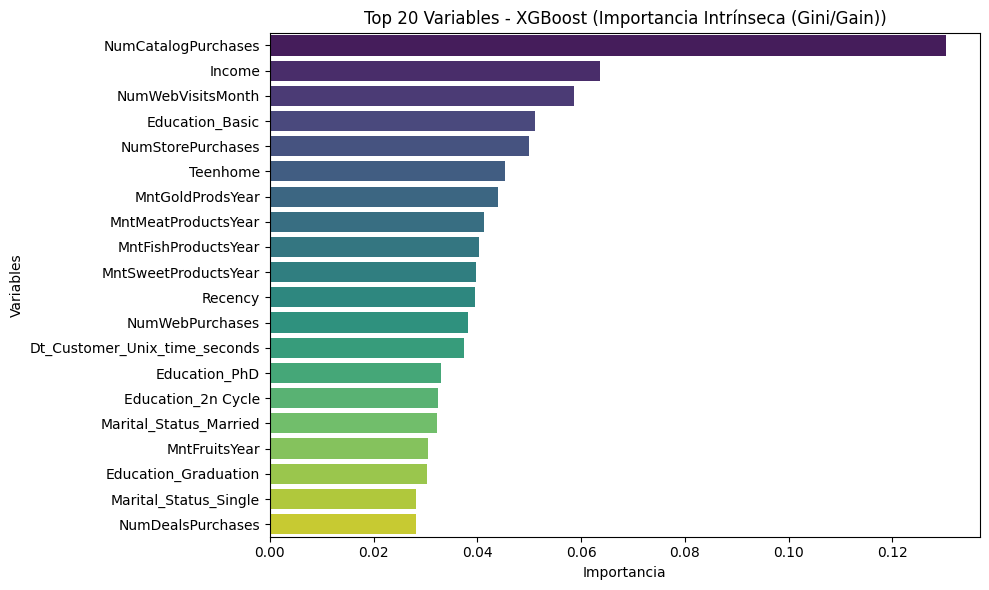

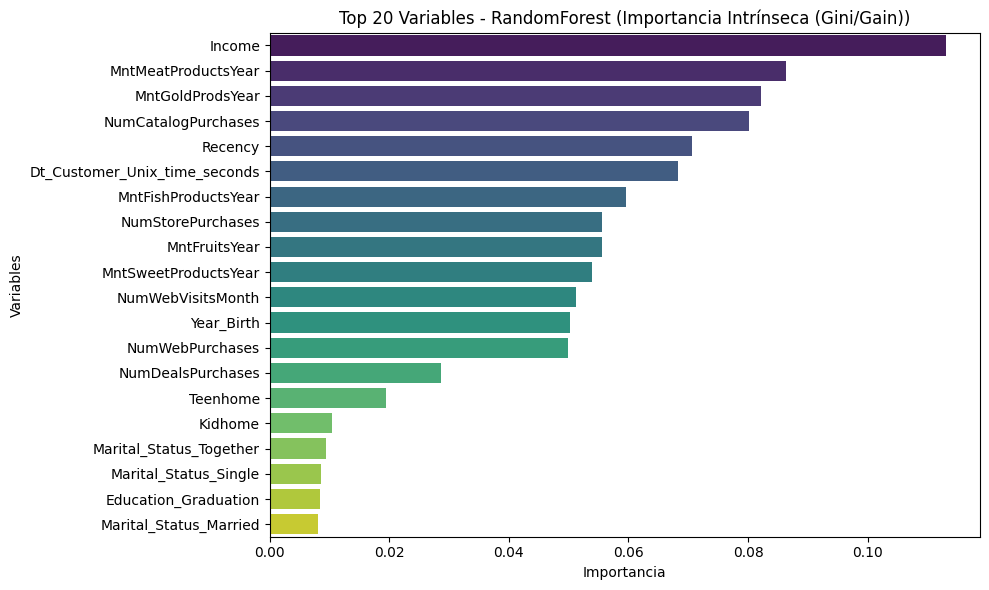

Calculando Permutation Importance para SVM...


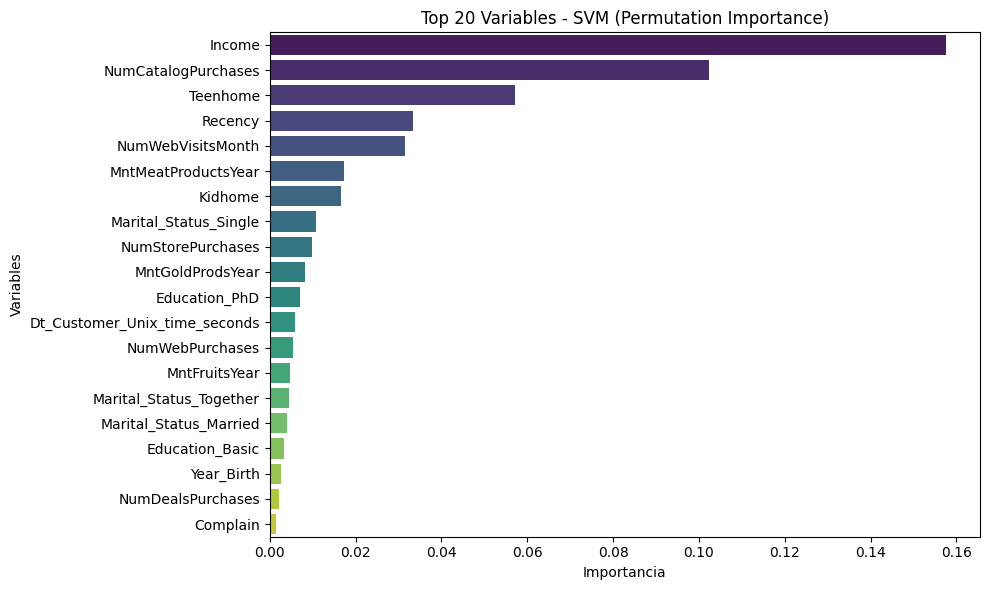

In [13]:
# -------------------------------------------------------------------------
# 5. IMPORTANCIA DE VARIABLES
# -------------------------------------------------------------------------
def plot_feature_importance(model_pipeline, model_name, X_data, y_data, feature_names):
    
    model_step = model_pipeline.named_steps['model']
    importances = None
    method_name = ""

    # Árboles (XGBoost, RF)
    if hasattr(model_step, 'feature_importances_'):
        importances = model_step.feature_importances_
        method_name = "Importancia Intrínseca (Gini/Gain)"
        
    # SVM (Permutation Importance)
    else:
        print(f"Calculando Permutation Importance para {model_name}...")
        perm_result = permutation_importance(
            model_pipeline, X_data, y_data, 
            n_repeats=5, random_state=42, scoring='roc_auc'
        )
        importances = perm_result.importances_mean
        method_name = "Permutation Importance"

    # Plot
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(20) # Top 20

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='Importance', 
        y='Feature', 
        data=feature_imp_df, 
        palette='viridis',
        hue='Feature' # Asignar hue a Feature para evitar advertencia de deprecación futura
        )
    plt.title(f'Top 20 Variables - {model_name} ({method_name})')
    plt.xlabel('Importancia')
    plt.ylabel('Variables')
    plt.tight_layout()
    plt.show()

# Generar gráficos
feature_names = X_train.columns
for name, pipeline in best_models.items():
    plot_feature_importance(pipeline, name, X_test, y_test, feature_names)

In [11]:
# Al revisar la importancia que se da a las variables , vemos que en apariencia SVM podría hacer mejores predicciones con 
# menos variables. Esto sería una ventaja si tuviéramos mucha fricción para conseguir ciertos datos de cliente.

# Sin embargo, dado que ya disponemos de todos los datos de cliente y de sus hábitos en nuestro sistema, nos vamos 
# a XGBoost por ser el que mejores métricas nos da, tanto en ROC_AUC como en Recall que es lo que más nos interesa.
# Los hiperparámetros a utilizar son estos:


# scale_pos_weight = total_negativos / total_positivos
ratio_balanceo = (y_train == 0).sum() / (y_train == 1).sum()


best_model_selected = Pipeline([
                        ('scaler', MinMaxScaler()), 
                        ('model', XGBClassifier(
                                    objective='binary:logistic', 
                                    eval_metric='logloss', 
                                    scale_pos_weight=ratio_balanceo,
                                    random_state=42,
                                    n_estimators=120,
                                    learning_rate=0.08,
                                    max_depth=3,
                                    subsample=0.8
                                ))
                    ])

In [12]:
# Nos aseguramos de que responde como esperamos:
best_model_selected.fit(X_train, y_train)
y_pred = best_model_selected.predict(X_test)

# Predicción de probabilidades (para ROC AUC)
y_proba = best_model_selected.predict_proba(X_test)[:, 1]

# Métricas
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
rec = recall_score(y_test, y_pred)      # Importante: Capacidad de encontrar los 1s
prec = precision_score(y_test, y_pred)  # Importante: Cuántos de los que dijimos 1 son realmente 1
f1 = f1_score(y_test, y_pred)

results = {
    'ROC AUC': roc, 
    'Recall (Sensibilidad)': rec, 
    'Precision': prec,
    'F1 Score': f1,
    'Accuracy': acc
}

for metric_name, metric_value in results.items():
    print(f"{metric_name}: {metric_value}")



ROC AUC: 0.85829782865356
Recall (Sensibilidad): 0.7933884297520661
Precision: 0.6037735849056604
F1 Score: 0.6857142857142857
Accuracy: 0.801354401805869


In [ ]:
# Se trata de los resultados esperados, ya tenemos nuestro modelo funcionando